In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import Model
from keras.constraints import min_max_norm
import keras.optimizers as optimizers
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# import sys
import matplotlib.dates as mdates
import datetime as dt
import time
import h5py
import keras.backend as K
from keras.models import load_model
import tensorflow as tf
from keras.constraints import min_max_norm
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)

Using TensorFlow backend.


In [10]:


dataset = pandas.read_csv('data_new/DowJones2.csv', skiprows=list(range(1, 2674)))['Close']
percent_inc = []
for i in range(1, len(dataset)):
    percent_inc.append((dataset[i]-dataset[i-1])/dataset[i])
percent_inc = numpy.array(percent_inc)

# ranges < -0.02 | -0.02 - -0.01 | -0.01 - -0.005 | -0.005 - 0 | 0 - 0.005 | 0.005 - 0.01 | 0.01 - 0.02 | > 0.02
ranges = [-4, -3, -2, -1, 1, 2, 3, 4]
trend_inc = []
for i in range(len(percent_inc)):
    if percent_inc[i] < -0.005:
        trend_inc.append(-4)
    elif percent_inc[i] < -0.002:
        trend_inc.append(-3)
    elif percent_inc[i] < -0.001:
        trend_inc.append(-2)
    elif percent_inc[i] < 0:
        trend_inc.append(-1)
    elif percent_inc[i] < 0.001:
        trend_inc.append(1)
    elif percent_inc[i] < 0.002:
        trend_inc.append(2)
    elif percent_inc[i] < 0.005:
        trend_inc.append(3)
    else:
        trend_inc.append(4)

trend_inc = list(map(lambda x: x/4, trend_inc))
trend_inc = numpy.array(trend_inc).reshape(-1, 1)
percent_inc = percent_inc.reshape(-1, 1)

def create_dataset(dataset, look_back=1, day_ahead=1, train_size=50):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(dataset) - look_back*day_ahead - day_ahead+1):
        x = dataset[i:i+look_back*day_ahead:day_ahead]
        if i < train_size:
            trainX.append(x)
#             trainY.append(dataset[i+look_back+day_ahead-1])
            trainY.append(numpy.zeros(8))
            trainY[-1][ranges.index(int(dataset[i+look_back*day_ahead]*4))] = 1
#             if dataset[i+look_back+day_ahead-1] > 0:
#                 trainY.append([0, 1])
#             else:
#                 trainY.append([1, 0])
        else:
            testX.append(x)
#             testY.append(dataset[i+look_back+day_ahead-1])
            testY.append(numpy.zeros(8))
            testY[-1][ranges.index(int(dataset[i+look_back*day_ahead]*4))] = 1
#             if dataset[i+look_back+day_ahead-1] > 0:
#                 testY.append([0, 1])
#             else:
#                 testY.append([1, 0])
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)

def _evaluate(x, y):
    predicts = model.predict(x).tolist()
    global corrects
    corrects = []
    for i in range(len(predicts)):
        index_max_predict = predicts[i].index(max(predicts[i]))
        index_max_reality = y[i].tolist().index(max(y[i]))
        if int(index_max_predict/4) == int(index_max_reality/4):
            corrects.append(1)
        else:
            corrects.append(0)
    return numpy.mean(corrects)
def _evaluate_sigmoid(x, y):
    predicts = model.predict(x).reshape(-1).tolist()
    global corrects
    corrects = []
    for i in range(len(predicts)):
        if predicts[i]*y[i][0] >= 0:
            corrects.append(1)
        else:
            corrects.append(0)
    return numpy.mean(corrects)


window_size = 5
day_ahead = 22
results = []

train_size=260
train_x, train_y, test_x, test_y = create_dataset(trend_inc, window_size, day_ahead, train_size)
# train_x, cross_trainx = train_x[:253], train_x[253:]
# train_y, cross_trainy = train_y[:253], train_y[253:]

model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1), return_sequences=False))
# model.add(LSTM(32, input_shape=(window_size, 1)))
model.add(Dense(40))
# model.add(Dropout(.2))
model.add(Dense(8, activation='softmax'))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['acc'])

# # hist = model.fit(train_x, train_y, epochs=1970, batch_size=200, verbose=1)
# # print(_evaluate(test_x, test_y))
# # print( str(_evaluate(test_x[:5], test_y[:5])) + ', ' + str(_evaluate(test_x, test_y)))

# hist = model.fit(train_x, train_y, epochs=400, batch_size=40, verbose=0)
# print(hist.history['loss'][-1], hist.his, _evaluate(train_x, train_y), _evaluate(test_x, test_y))

for i in range(2600):
    hist = model.fit(train_x, train_y, epochs=1, batch_size=40, verbose=0)
    eva_test = _evaluate(test_x, test_y)
#     eva_cross = _evaluate(cross_trainx, cross_trainy)
    eva_train = _evaluate(train_x, train_y)
#     eva = _evaluate_sigmoid(test_x, test_y)
#     eva = model.evaluate(test_x, test_y, verbose=0)[1]
    results.append([i, eva_test, hist.history['acc'][-1], eva_train])
    print(i, hist.history, eva_train, eva_test)

0 {'loss': [2.0473199440882754], 'acc': [0.19230769460017866]} 0.523076923077 0.52380952381
1 {'loss': [1.9912295524890606], 'acc': [0.24230769276618958]} 0.538461538462 0.561904761905
2 {'loss': [1.9802263149848351], 'acc': [0.22692308059105507]} 0.542307692308 0.552380952381
3 {'loss': [1.9754469027886024], 'acc': [0.23461538610550073]} 0.534615384615 0.528571428571
4 {'loss': [1.9715720873612623], 'acc': [0.242307692193068]} 0.534615384615 0.52380952381
5 {'loss': [1.9670638304490309], 'acc': [0.25]} 0.530769230769 0.528571428571
6 {'loss': [1.963522507594182], 'acc': [0.24615384523685163]} 0.515384615385 0.519047619048
7 {'loss': [1.9621271903698261], 'acc': [0.25384615304378361]} 0.511538461538 0.519047619048
8 {'loss': [1.9623189706068773], 'acc': [0.25000000143280399]} 0.523076923077 0.514285714286
9 {'loss': [1.9596338822291448], 'acc': [0.24999999770751366]} 0.530769230769 0.52380952381
10 {'loss': [1.9582119079736562], 'acc': [0.24230769735116225]} 0.538461538462 0.5333333333

90 {'loss': [1.9163476137014537], 'acc': [0.25384615247066206]} 0.546153846154 0.471428571429
91 {'loss': [1.9161661496529212], 'acc': [0.25000000229248631]} 0.546153846154 0.461904761905
92 {'loss': [1.9156785011291504], 'acc': [0.25]} 0.546153846154 0.471428571429
93 {'loss': [1.9154992837172289], 'acc': [0.25769231296502626]} 0.546153846154 0.471428571429
94 {'loss': [1.9159838969890888], 'acc': [0.25]} 0.542307692308 0.466666666667
95 {'loss': [1.9155955864832952], 'acc': [0.25384615476314837]} 0.538461538462 0.471428571429
96 {'loss': [1.9142958384293776], 'acc': [0.25384615705563474]} 0.538461538462 0.480952380952
97 {'loss': [1.9138042376591609], 'acc': [0.25384615476314837]} 0.538461538462 0.480952380952
98 {'loss': [1.9135158887276282], 'acc': [0.25769230952629674]} 0.542307692308 0.471428571429
99 {'loss': [1.9127143621444702], 'acc': [0.25384615705563474]} 0.542307692308 0.466666666667
100 {'loss': [1.9132887583512526], 'acc': [0.25384615247066206]} 0.538461538462 0.47142857

179 {'loss': [1.891102515734159], 'acc': [0.25]} 0.55 0.509523809524
180 {'loss': [1.891284704208374], 'acc': [0.2538461513244189]} 0.546153846154 0.504761904762
181 {'loss': [1.8903234096673818], 'acc': [0.25000000458497268]} 0.55 0.509523809524
182 {'loss': [1.8898067290966327], 'acc': [0.24999999770751366]} 0.553846153846 0.5
183 {'loss': [1.889431696671706], 'acc': [0.25384615247066206]} 0.55 0.504761904762
184 {'loss': [1.8891223393953764], 'acc': [0.25000000343872952]} 0.55 0.5
185 {'loss': [1.8891453101084783], 'acc': [0.25384615934812105]} 0.55 0.509523809524
186 {'loss': [1.8891011384817271], 'acc': [0.25000000229248631]} 0.553846153846 0.519047619048
187 {'loss': [1.8891223210554857], 'acc': [0.25]} 0.557692307692 0.504761904762
188 {'loss': [1.8878080569780791], 'acc': [0.25000000229248631]} 0.553846153846 0.504761904762
189 {'loss': [1.8877867918748121], 'acc': [0.25384615247066206]} 0.561538461538 0.504761904762
190 {'loss': [1.8885238078924327], 'acc': [0.2615384665819314

268 {'loss': [1.8600227190898015], 'acc': [0.24615384523685163]} 0.561538461538 0.557142857143
269 {'loss': [1.8597512611976037], 'acc': [0.24615384294436529]} 0.565384615385 0.561904761905
270 {'loss': [1.8587679129380446], 'acc': [0.25384615476314837]} 0.561538461538 0.557142857143
271 {'loss': [1.8591780845935528], 'acc': [0.24615384179812211]} 0.565384615385 0.552380952381
272 {'loss': [1.8583341745229869], 'acc': [0.25384615017817569]} 0.565384615385 0.547619047619
273 {'loss': [1.8583417855776274], 'acc': [0.25384615017817569]} 0.565384615385 0.552380952381
274 {'loss': [1.8581023674744825], 'acc': [0.25000000229248631]} 0.565384615385 0.557142857143
275 {'loss': [1.8582082895132213], 'acc': [0.24615384752933794]} 0.561538461538 0.561904761905
276 {'loss': [1.8568670841363759], 'acc': [0.25384615476314837]} 0.553846153846 0.561904761905
277 {'loss': [1.8566987055998583], 'acc': [0.2576923118187831]} 0.557692307692 0.566666666667
278 {'loss': [1.8565132984748254], 'acc': [0.250000

358 {'loss': [1.8306195735931396], 'acc': [0.25769230723381042]} 0.553846153846 0.561904761905
359 {'loss': [1.8302389475015493], 'acc': [0.25769230723381042]} 0.55 0.566666666667
360 {'loss': [1.8293701135195219], 'acc': [0.26153846428944516]} 0.553846153846 0.561904761905
361 {'loss': [1.8304357712085431], 'acc': [0.25384615247066206]} 0.546153846154 0.566666666667
362 {'loss': [1.8290375196016753], 'acc': [0.26538461905259353]} 0.546153846154 0.566666666667
363 {'loss': [1.8283845094534068], 'acc': [0.25769230723381042]} 0.55 0.561904761905
364 {'loss': [1.8286227996532733], 'acc': [0.26153845970447248]} 0.542307692308 0.561904761905
365 {'loss': [1.8281751962808461], 'acc': [0.26153846658193147]} 0.557692307692 0.561904761905
366 {'loss': [1.8276891616674571], 'acc': [0.26538461905259353]} 0.553846153846 0.57619047619
367 {'loss': [1.8278117821766779], 'acc': [0.26538461504074246]} 0.55 0.561904761905
368 {'loss': [1.8275664586287279], 'acc': [0.26538461676010716]} 0.557692307692 0

446 {'loss': [1.8063049499805157], 'acc': [0.28846153502280897]} 0.592307692308 0.566666666667
447 {'loss': [1.8058273700567393], 'acc': [0.29230768978595734]} 0.596153846154 0.57619047619
448 {'loss': [1.8060697408822866], 'acc': [0.29615384798783523]} 0.596153846154 0.571428571429
449 {'loss': [1.8049526306299062], 'acc': [0.3038461540754025]} 0.603846153846 0.566666666667
450 {'loss': [1.8054775366416345], 'acc': [0.29615384569534886]} 0.607692307692 0.571428571429
451 {'loss': [1.8042354583740234], 'acc': [0.30384615980661833]} 0.611538461538 0.571428571429
452 {'loss': [1.8052274538920476], 'acc': [0.29230769093220049]} 0.603846153846 0.571428571429
453 {'loss': [1.8036538545901959], 'acc': [0.29999999816601092]} 0.603846153846 0.571428571429
454 {'loss': [1.8043411878439097], 'acc': [0.29230769093220049]} 0.603846153846 0.57619047619
455 {'loss': [1.8038746210244985], 'acc': [0.29615384340286255]} 0.6 0.571428571429
456 {'loss': [1.8035449614891639], 'acc': [0.29615384569534886]}

536 {'loss': [1.7821694979300866], 'acc': [0.31923077198175281]} 0.619230769231 0.580952380952
537 {'loss': [1.7811225744394155], 'acc': [0.32307692215992856]} 0.615384615385 0.585714285714
538 {'loss': [1.7812569691584661], 'acc': [0.31538461951109081]} 0.615384615385 0.580952380952
539 {'loss': [1.7818270463209887], 'acc': [0.31923077656672549]} 0.607692307692 0.571428571429
540 {'loss': [1.7814093002906213], 'acc': [0.30769230539982134]} 0.615384615385 0.571428571429
541 {'loss': [1.780465236076942], 'acc': [0.31538461492611813]} 0.626923076923 0.57619047619
542 {'loss': [1.7808195169155414], 'acc': [0.32692307233810425]} 0.619230769231 0.580952380952
543 {'loss': [1.7804124171917255], 'acc': [0.32692307692307693]} 0.623076923077 0.580952380952
544 {'loss': [1.7795198697310228], 'acc': [0.33076923397871166]} 0.626923076923 0.580952380952
545 {'loss': [1.7799508479925303], 'acc': [0.32692307921556324]} 0.615384615385 0.571428571429
546 {'loss': [1.7794156074523926], 'acc': [0.3192307

624 {'loss': [1.755968295610868], 'acc': [0.31923076510429382]} 0.603846153846 0.57619047619
625 {'loss': [1.7544675606947679], 'acc': [0.31923076510429382]} 0.603846153846 0.57619047619
626 {'loss': [1.754499105306772], 'acc': [0.32692308150804961]} 0.603846153846 0.57619047619
627 {'loss': [1.7552902973615205], 'acc': [0.31923076739678014]} 0.607692307692 0.580952380952
628 {'loss': [1.7536960931924672], 'acc': [0.32307692215992856]} 0.603846153846 0.57619047619
629 {'loss': [1.7537972927093506], 'acc': [0.31923077198175281]} 0.603846153846 0.57619047619
630 {'loss': [1.7538727796994722], 'acc': [0.31923076739678014]} 0.603846153846 0.57619047619
631 {'loss': [1.7533763647079468], 'acc': [0.32307692445241487]} 0.603846153846 0.57619047619
632 {'loss': [1.7520233484414907], 'acc': [0.32307691872119904]} 0.603846153846 0.590476190476
633 {'loss': [1.752478654568012], 'acc': [0.32307692445241487]} 0.607692307692 0.590476190476
634 {'loss': [1.7520624765982995], 'acc': [0.315384614926118

715 {'loss': [1.7204828812525823], 'acc': [0.31538461951109081]} 0.588461538462 0.6
716 {'loss': [1.7196981356694148], 'acc': [0.31538461263363177]} 0.592307692308 0.604761904762
717 {'loss': [1.7192416191101074], 'acc': [0.31923076739678014]} 0.592307692308 0.604761904762
718 {'loss': [1.7187946209540734], 'acc': [0.32307692445241487]} 0.592307692308 0.609523809524
719 {'loss': [1.7181639579626231], 'acc': [0.31538461721860445]} 0.592307692308 0.604761904762
720 {'loss': [1.7178545181567852], 'acc': [0.3192307696892665]} 0.592307692308 0.604761904762
721 {'loss': [1.717524950320904], 'acc': [0.31538461091426701]} 0.592307692308 0.604761904762
722 {'loss': [1.7170737156501183], 'acc': [0.31153846016296971]} 0.584615384615 0.595238095238
723 {'loss': [1.7166657081017127], 'acc': [0.31923077427423918]} 0.584615384615 0.595238095238
724 {'loss': [1.7158380104945257], 'acc': [0.30769230769230771]} 0.588461538462 0.6
725 {'loss': [1.7151411129878118], 'acc': [0.31153846245545608]} 0.5923076

805 {'loss': [1.6758274298447828], 'acc': [0.3307692316862253]} 0.588461538462 0.604761904762
806 {'loss': [1.6758718582300038], 'acc': [0.3307692316862253]} 0.592307692308 0.609523809524
807 {'loss': [1.6752211038882916], 'acc': [0.3307692316862253]} 0.592307692308 0.6
808 {'loss': [1.6742839904931874], 'acc': [0.3307692316862253]} 0.592307692308 0.6
809 {'loss': [1.6739417039431059], 'acc': [0.33076923397871166]} 0.596153846154 0.614285714286
810 {'loss': [1.6734154407794659], 'acc': [0.33846153433506304]} 0.592307692308 0.6
811 {'loss': [1.6729121024792011], 'acc': [0.33076923397871166]} 0.6 0.6
812 {'loss': [1.6723645375325129], 'acc': [0.3346153830106442]} 0.596153846154 0.595238095238
813 {'loss': [1.672128704878], 'acc': [0.33461538644937366]} 0.596153846154 0.595238095238
814 {'loss': [1.6720859545927782], 'acc': [0.33076923397871166]} 0.596153846154 0.6
815 {'loss': [1.6708095073699951], 'acc': [0.33461538186440098]} 0.596153846154 0.6
816 {'loss': [1.6699212422737708], 'acc':

898 {'loss': [1.6266315900362456], 'acc': [0.35000000091699451]} 0.607692307692 0.62380952381
899 {'loss': [1.6257330729411199], 'acc': [0.34615384386135983]} 0.607692307692 0.62380952381
900 {'loss': [1.6253242859473596], 'acc': [0.35384615109517026]} 0.603846153846 0.62380952381
901 {'loss': [1.6243774524101844], 'acc': [0.34615384156887347]} 0.607692307692 0.62380952381
902 {'loss': [1.6245780541346624], 'acc': [0.34999999403953552]} 0.615384615385 0.628571428571
903 {'loss': [1.6240110397338867], 'acc': [0.35384614651019758]} 0.611538461538 0.619047619048
904 {'loss': [1.6229729102208064], 'acc': [0.35769231273577762]} 0.611538461538 0.62380952381
905 {'loss': [1.6231658917206984], 'acc': [0.35384614880268389]} 0.603846153846 0.62380952381
906 {'loss': [1.6219439689929669], 'acc': [0.35384615338765657]} 0.603846153846 0.628571428571
907 {'loss': [1.6212391211436346], 'acc': [0.3499999986245082]} 0.611538461538 0.628571428571
908 {'loss': [1.6207388731149526], 'acc': [0.353846151095

988 {'loss': [1.581080858524029], 'acc': [0.35769231044329131]} 0.615384615385 0.609523809524
989 {'loss': [1.5804812816473155], 'acc': [0.35769231044329131]} 0.611538461538 0.609523809524
990 {'loss': [1.5802915004583507], 'acc': [0.35769230585831863]} 0.611538461538 0.6
991 {'loss': [1.5793601182790904], 'acc': [0.36153846062146699]} 0.615384615385 0.604761904762
992 {'loss': [1.5793804297080407], 'acc': [0.36923077014776379]} 0.619230769231 0.604761904762
993 {'loss': [1.5786178020330577], 'acc': [0.36538461996958804]} 0.615384615385 0.604761904762
994 {'loss': [1.5779408033077533], 'acc': [0.36923077014776379]} 0.619230769231 0.609523809524
995 {'loss': [1.5772485182835505], 'acc': [0.36923077473273647]} 0.623076923077 0.609523809524
996 {'loss': [1.5777870049843421], 'acc': [0.36538461767710173]} 0.626923076923 0.609523809524
997 {'loss': [1.5765156745910645], 'acc': [0.37307692032593948]} 0.626923076923 0.609523809524
998 {'loss': [1.5764633325430064], 'acc': [0.36923077473273647

1076 {'loss': [1.5403388096736028], 'acc': [0.38461538461538464]} 0.638461538462 0.628571428571
1077 {'loss': [1.5408077331689687], 'acc': [0.38846153479356033]} 0.646153846154 0.62380952381
1078 {'loss': [1.5400439500808716], 'acc': [0.39230769414168137]} 0.646153846154 0.619047619048
1079 {'loss': [1.5391324850229116], 'acc': [0.39615384431985706]} 0.65 0.614285714286
1080 {'loss': [1.5387889605302076], 'acc': [0.38461538920035732]} 0.638461538462 0.628571428571
1081 {'loss': [1.5390883500759418], 'acc': [0.38076923443720889]} 0.638461538462 0.619047619048
1082 {'loss': [1.5382244495245128], 'acc': [0.39230769414168137]} 0.638461538462 0.614285714286
1083 {'loss': [1.5375190147986779], 'acc': [0.38846153708604664]} 0.646153846154 0.628571428571
1084 {'loss': [1.5372165533212514], 'acc': [0.39999999908300549]} 0.642307692308 0.628571428571
1085 {'loss': [1.5368604751733632], 'acc': [0.38076922985223621]} 0.638461538462 0.633333333333
1086 {'loss': [1.5359963912230272], 'acc': [0.38846

1164 {'loss': [1.5034482479095459], 'acc': [0.40000000366797817]} 0.657692307692 0.609523809524
1165 {'loss': [1.5031631084588857], 'acc': [0.40384615843112653]} 0.661538461538 0.609523809524
1166 {'loss': [1.502951667859004], 'acc': [0.41153846795742327]} 0.661538461538 0.604761904762
1167 {'loss': [1.5017682772416334], 'acc': [0.40384615843112653]} 0.661538461538 0.609523809524
1168 {'loss': [1.5015106384570782], 'acc': [0.40384615384615385]} 0.661538461538 0.609523809524
1169 {'loss': [1.5012051508976862], 'acc': [0.41153846107996428]} 0.661538461538 0.609523809524
1170 {'loss': [1.5003503010823176], 'acc': [0.41153846337245059]} 0.661538461538 0.604761904762
1171 {'loss': [1.5014544083521917], 'acc': [0.40769230402432954]} 0.665384615385 0.609523809524
1172 {'loss': [1.4994665475992055], 'acc': [0.4192307683137747]} 0.661538461538 0.604761904762
1173 {'loss': [1.5000211092141957], 'acc': [0.41538461813559902]} 0.657692307692 0.604761904762
1174 {'loss': [1.4995154325778668], 'acc':

1254 {'loss': [1.4677156026546772], 'acc': [0.41923077289874738]} 0.653846153846 0.595238095238
1255 {'loss': [1.4663405693494356], 'acc': [0.42307692307692307]} 0.657692307692 0.595238095238
1256 {'loss': [1.4664901219881499], 'acc': [0.42307691390697771]} 0.661538461538 0.604761904762
1257 {'loss': [1.4665352931389442], 'acc': [0.42692307784007144]} 0.661538461538 0.604761904762
1258 {'loss': [1.4653591834581816], 'acc': [0.42692307554758513]} 0.657692307692 0.604761904762
1259 {'loss': [1.4650777119856615], 'acc': [0.41538461584311265]} 0.661538461538 0.6
1260 {'loss': [1.465313196182251], 'acc': [0.42307692078443676]} 0.661538461538 0.6
1261 {'loss': [1.4648396510344286], 'acc': [0.41923076487504518]} 0.669230769231 0.595238095238
1262 {'loss': [1.4645411326335027], 'acc': [0.42307692307692307]} 0.665384615385 0.595238095238
1263 {'loss': [1.4643114805221558], 'acc': [0.42307692078443676]} 0.665384615385 0.6
1264 {'loss': [1.4633422998281627], 'acc': [0.4192307683137747]} 0.6615384

1344 {'loss': [1.4318785850818341], 'acc': [0.43461538048890919]} 0.688461538462 0.6
1345 {'loss': [1.4314908614525428], 'acc': [0.43846153983703029]} 0.688461538462 0.595238095238
1346 {'loss': [1.4312767248887281], 'acc': [0.44615384477835435]} 0.688461538462 0.595238095238
1347 {'loss': [1.4310007003637462], 'acc': [0.44615384477835435]} 0.688461538462 0.595238095238
1348 {'loss': [1.43054526585799], 'acc': [0.43461539195134091]} 0.684615384615 0.590476190476
1349 {'loss': [1.4304829469093909], 'acc': [0.44230769230769229]} 0.680769230769 0.595238095238
1350 {'loss': [1.4294706307924712], 'acc': [0.4384615421295166]} 0.676923076923 0.6
1351 {'loss': [1.4293330265925481], 'acc': [0.4307692303107335]} 0.673076923077 0.6
1352 {'loss': [1.4291013387533336], 'acc': [0.43461538278139555]} 0.669230769231 0.595238095238
1353 {'loss': [1.4287459025016198], 'acc': [0.42692307784007144]} 0.669230769231 0.590476190476
1354 {'loss': [1.4279170861610999], 'acc': [0.42307691390697771]} 0.673076923

1432 {'loss': [1.3984781411977916], 'acc': [0.43461539195134091]} 0.669230769231 0.590476190476
1433 {'loss': [1.3968485960593591], 'acc': [0.43461537819642287]} 0.669230769231 0.595238095238
1434 {'loss': [1.3971627583870521], 'acc': [0.43846153754454392]} 0.669230769231 0.595238095238
1435 {'loss': [1.3968670459894033], 'acc': [0.44230770377012402]} 0.676923076923 0.6
1436 {'loss': [1.3964778184890747], 'acc': [0.4384615421295166]} 0.676923076923 0.590476190476
1437 {'loss': [1.3959432656948383], 'acc': [0.44615384019338167]} 0.680769230769 0.595238095238
1438 {'loss': [1.3951325599963849], 'acc': [0.43846153525205761]} 0.680769230769 0.6
1439 {'loss': [1.3945563756502593], 'acc': [0.44230769689266497]} 0.680769230769 0.590476190476
1440 {'loss': [1.3949698026363666], 'acc': [0.43846153754454392]} 0.676923076923 0.585714285714
1441 {'loss': [1.3944025956667387], 'acc': [0.45384614742719209]} 0.676923076923 0.585714285714
1442 {'loss': [1.3938985696205726], 'acc': [0.45000000871144807

1518 {'loss': [1.3658617459810698], 'acc': [0.45384615430465114]} 0.688461538462 0.580952380952
1519 {'loss': [1.3663030220912054], 'acc': [0.46153846153846156]} 0.676923076923 0.566666666667
1520 {'loss': [1.3648462662330041], 'acc': [0.46538461630160993]} 0.673076923077 0.561904761905
1521 {'loss': [1.3650709115541899], 'acc': [0.45769230219034046]} 0.680769230769 0.566666666667
1522 {'loss': [1.3642746210098267], 'acc': [0.46153846383094788]} 0.676923076923 0.561904761905
1523 {'loss': [1.3633781396425688], 'acc': [0.45769231136028582]} 0.676923076923 0.571428571429
1524 {'loss': [1.3630340282733624], 'acc': [0.46153846383094788]} 0.676923076923 0.571428571429
1525 {'loss': [1.3627297878265381], 'acc': [0.46153845695348888]} 0.684615384615 0.57619047619
1526 {'loss': [1.3624268311720629], 'acc': [0.46538461171663725]} 0.684615384615 0.57619047619
1527 {'loss': [1.3621280376727765], 'acc': [0.46538462547155529]} 0.676923076923 0.57619047619
1528 {'loss': [1.3622817167868981], 'acc': 

1604 {'loss': [1.3346886726526113], 'acc': [0.46923076418729931]} 0.680769230769 0.580952380952
1605 {'loss': [1.3352211346993079], 'acc': [0.46538461630160993]} 0.680769230769 0.571428571429
1606 {'loss': [1.3338015996492827], 'acc': [0.46923076877227199]} 0.673076923077 0.57619047619
1607 {'loss': [1.3329828060590303], 'acc': [0.46923077564973098]} 0.680769230769 0.57619047619
1608 {'loss': [1.3335132048680232], 'acc': [0.46923075730984026]} 0.673076923077 0.57619047619
1609 {'loss': [1.3324471437014067], 'acc': [0.46153845809973204]} 0.680769230769 0.585714285714
1610 {'loss': [1.3329579004874597], 'acc': [0.46153844778354353]} 0.673076923077 0.580952380952
1611 {'loss': [1.3321352096704335], 'acc': [0.46538461630160993]} 0.676923076923 0.57619047619
1612 {'loss': [1.3324404863210826], 'acc': [0.45769230448282683]} 0.680769230769 0.585714285714
1613 {'loss': [1.3315006953019362], 'acc': [0.46538460942415089]} 0.680769230769 0.580952380952
1614 {'loss': [1.3313251000184279], 'acc': [

1690 {'loss': [1.3032913574805627], 'acc': [0.4692307710647583]} 0.676923076923 0.585714285714
1691 {'loss': [1.3030482989091139], 'acc': [0.46923076418729931]} 0.673076923077 0.580952380952
1692 {'loss': [1.3030621822063739], 'acc': [0.47307691895044768]} 0.680769230769 0.580952380952
1693 {'loss': [1.3024591941099901], 'acc': [0.47307691895044768]} 0.680769230769 0.585714285714
1694 {'loss': [1.3030686195080097], 'acc': [0.46923076647978562]} 0.684615384615 0.57619047619
1695 {'loss': [1.3020005868031428], 'acc': [0.47307692697414983]} 0.684615384615 0.57619047619
1696 {'loss': [1.3018071834857647], 'acc': [0.47692306454365069]} 0.688461538462 0.57619047619
1697 {'loss': [1.3018015531393199], 'acc': [0.47307692124293399]} 0.688461538462 0.57619047619
1698 {'loss': [1.3004179275952852], 'acc': [0.48461537636243379]} 0.684615384615 0.580952380952
1699 {'loss': [1.3006604451399584], 'acc': [0.47692307142110973]} 0.673076923077 0.580952380952
1700 {'loss': [1.3000595477911143], 'acc': [0

1777 {'loss': [1.2731037048193126], 'acc': [0.49230769964364857]} 0.692307692308 0.585714285714
1778 {'loss': [1.2727870574364295], 'acc': [0.48846153571055484]} 0.688461538462 0.585714285714
1779 {'loss': [1.2720349476887629], 'acc': [0.48076923535420346]} 0.684615384615 0.585714285714
1780 {'loss': [1.2718034157386193], 'acc': [0.48461538553237915]} 0.684615384615 0.585714285714
1781 {'loss': [1.2710270239756658], 'acc': [0.48076923076923078]} 0.680769230769 0.580952380952
1782 {'loss': [1.271052360534668], 'acc': [0.48076922389177174]} 0.680769230769 0.585714285714
1783 {'loss': [1.2706823257299571], 'acc': [0.48461538782486546]} 0.684615384615 0.585714285714
1784 {'loss': [1.2705559730529785], 'acc': [0.48846154258801389]} 0.688461538462 0.585714285714
1785 {'loss': [1.2698360956632173], 'acc': [0.47692308059105504]} 0.688461538462 0.585714285714
1786 {'loss': [1.2696720361709595], 'acc': [0.48076923535420346]} 0.680769230769 0.585714285714
1787 {'loss': [1.2694369371120746], 'acc'

1863 {'loss': [1.2415262644107525], 'acc': [0.48846153571055484]} 0.692307692308 0.580952380952
1864 {'loss': [1.2410067044771635], 'acc': [0.5]} 0.692307692308 0.585714285714
1865 {'loss': [1.2404381128457875], 'acc': [0.5]} 0.692307692308 0.57619047619
1866 {'loss': [1.2397029216472919], 'acc': [0.5]} 0.692307692308 0.57619047619
1867 {'loss': [1.2400069786952093], 'acc': [0.49230769047370326]} 0.692307692308 0.580952380952
1868 {'loss': [1.2393397826414843], 'acc': [0.49999999541502732]} 0.688461538462 0.585714285714
1869 {'loss': [1.2393096593710093], 'acc': [0.50000000458497262]} 0.688461538462 0.580952380952
1870 {'loss': [1.2389428432171161], 'acc': [0.49615384982182431]} 0.692307692308 0.585714285714
1871 {'loss': [1.239066637479342], 'acc': [0.49230768588873058]} 0.692307692308 0.585714285714
1872 {'loss': [1.2388149591592641], 'acc': [0.50000000458497262]} 0.688461538462 0.590476190476
1873 {'loss': [1.2381670291607196], 'acc': [0.49999999083005464]} 0.688461538462 0.58571428

1953 {'loss': [1.2084261270669789], 'acc': [0.51153845053452707]} 0.696153846154 0.566666666667
1954 {'loss': [1.2078996438246508], 'acc': [0.51538460529767549]} 0.7 0.566666666667
1955 {'loss': [1.2079822925420909], 'acc': [0.50769230952629674]} 0.7 0.571428571429
1956 {'loss': [1.2067523186023419], 'acc': [0.51538460988264823]} 0.7 0.57619047619
1957 {'loss': [1.2078497226421649], 'acc': [0.51923076693828285]} 0.7 0.571428571429
1958 {'loss': [1.2068401299990141], 'acc': [0.51153845970447243]} 0.696153846154 0.566666666667
1959 {'loss': [1.2063532700905433], 'acc': [0.51923076464579654]} 0.696153846154 0.571428571429
1960 {'loss': [1.205497567470257], 'acc': [0.51923075776833749]} 0.707692307692 0.571428571429
1961 {'loss': [1.2053676660244281], 'acc': [0.51923076464579654]} 0.696153846154 0.57619047619
1962 {'loss': [1.2050373370830829], 'acc': [0.51538461446762085]} 0.696153846154 0.57619047619
1963 {'loss': [1.2043533691993127], 'acc': [0.50769230494132411]} 0.7 0.571428571429
196

2042 {'loss': [1.1753154259461622], 'acc': [0.51153846199695885]} 0.703846153846 0.571428571429
2043 {'loss': [1.175584050325247], 'acc': [0.52307691940894496]} 0.707692307692 0.571428571429
2044 {'loss': [1.17481529712677], 'acc': [0.52307691482397223]} 0.707692307692 0.571428571429
2045 {'loss': [1.1746226640848012], 'acc': [0.51538461905259347]} 0.707692307692 0.571428571429
2046 {'loss': [1.1745514686291034], 'acc': [0.52307691940894496]} 0.703846153846 0.571428571429
2047 {'loss': [1.174615740776062], 'acc': [0.52692308334203863]} 0.703846153846 0.571428571429
2048 {'loss': [1.173559280542227], 'acc': [0.51923076923076927]} 0.707692307692 0.566666666667
2049 {'loss': [1.1728928272540753], 'acc': [0.51923076923076927]} 0.707692307692 0.566666666667
2050 {'loss': [1.1728418148480928], 'acc': [0.52307692170143127]} 0.703846153846 0.566666666667
2051 {'loss': [1.1724548156444843], 'acc': [0.52307691940894496]} 0.7 0.571428571429
2052 {'loss': [1.1717370931918805], 'acc': [0.5076923095

2128 {'loss': [1.1437438909824078], 'acc': [0.55000001192092896]} 0.726923076923 0.571428571429
2129 {'loss': [1.1437472013326793], 'acc': [0.5500000027509836]} 0.723076923077 0.571428571429
2130 {'loss': [1.1436652174362769], 'acc': [0.54230768863971412]} 0.726923076923 0.566666666667
2131 {'loss': [1.1429016590118408], 'acc': [0.54615383881788993]} 0.726923076923 0.561904761905
2132 {'loss': [1.1427662005791297], 'acc': [0.54615384340286255]} 0.723076923077 0.561904761905
2133 {'loss': [1.1418313154807458], 'acc': [0.55384614834418666]} 0.730769230769 0.561904761905
2134 {'loss': [1.1415861111420851], 'acc': [0.54230769780965948]} 0.726923076923 0.561904761905
2135 {'loss': [1.1415851299579327], 'acc': [0.55769229393738962]} 0.719230769231 0.561904761905
2136 {'loss': [1.1406630919529841], 'acc': [0.54615384798783517]} 0.719230769231 0.561904761905
2137 {'loss': [1.1402744513291578], 'acc': [0.55769230081484866]} 0.715384615385 0.561904761905
2138 {'loss': [1.139756285227262], 'acc':

2214 {'loss': [1.1119086008805494], 'acc': [0.55769230081484866]} 0.730769230769 0.557142857143
2215 {'loss': [1.1127270551828237], 'acc': [0.56923076739678014]} 0.726923076923 0.557142857143
2216 {'loss': [1.1117737568341768], 'acc': [0.55769230769230771]} 0.730769230769 0.561904761905
2217 {'loss': [1.1112694923694317], 'acc': [0.56153846704042876]} 0.734615384615 0.557142857143
2218 {'loss': [1.1102380385765662], 'acc': [0.56538461951109076]} 0.734615384615 0.561904761905
2219 {'loss': [1.1113292987530048], 'acc': [0.56923078115169823]} 0.734615384615 0.557142857143
2220 {'loss': [1.1098127640210664], 'acc': [0.55769230310733497]} 0.730769230769 0.557142857143
2221 {'loss': [1.1100518520061786], 'acc': [0.56538461721860445]} 0.726923076923 0.557142857143
2222 {'loss': [1.1100793343323927], 'acc': [0.56153845328551077]} 0.726923076923 0.557142857143
2223 {'loss': [1.1086187362670898], 'acc': [0.56538462180357718]} 0.730769230769 0.557142857143
2224 {'loss': [1.1086452007293701], 'acc

2301 {'loss': [1.0815073297573969], 'acc': [0.5807692316862253]} 0.723076923077 0.561904761905
2302 {'loss': [1.0814366753284748], 'acc': [0.57692307692307687]} 0.723076923077 0.566666666667
2303 {'loss': [1.081572413444519], 'acc': [0.58076923627119803]} 0.723076923077 0.557142857143
2304 {'loss': [1.0804104713293223], 'acc': [0.58461538186440098]} 0.723076923077 0.557142857143
2305 {'loss': [1.0809129980894236], 'acc': [0.5807692316862253]} 0.723076923077 0.552380952381
2306 {'loss': [1.0798178177613478], 'acc': [0.56923076281180751]} 0.726923076923 0.557142857143
2307 {'loss': [1.0799092008517339], 'acc': [0.57692308150804961]} 0.723076923077 0.552380952381
2308 {'loss': [1.0801560970453115], 'acc': [0.57307691757495582]} 0.719230769231 0.552380952381
2309 {'loss': [1.0787149759439321], 'acc': [0.58076922710125267]} 0.723076923077 0.547619047619
2310 {'loss': [1.079071934406574], 'acc': [0.56538461951109076]} 0.726923076923 0.552380952381
2311 {'loss': [1.078952092390794], 'acc': [0

2388 {'loss': [1.0524228444466224], 'acc': [0.59999999633202183]} 0.734615384615 0.557142857143
2389 {'loss': [1.0518175409390376], 'acc': [0.59999999633202183]} 0.734615384615 0.557142857143
2390 {'loss': [1.0511690928385808], 'acc': [0.59999999633202183]} 0.734615384615 0.557142857143
2391 {'loss': [1.0511961258374727], 'acc': [0.59615384615384615]} 0.738461538462 0.557142857143
2392 {'loss': [1.0510288935441237], 'acc': [0.5961538553237915]} 0.738461538462 0.557142857143
2393 {'loss': [1.0504931394870465], 'acc': [0.5961538553237915]} 0.742307692308 0.557142857143
2394 {'loss': [1.0505035748848548], 'acc': [0.59999999633202183]} 0.738461538462 0.561904761905
2395 {'loss': [1.0496798203541682], 'acc': [0.60384614651019752]} 0.742307692308 0.571428571429
2396 {'loss': [1.0494693105037396], 'acc': [0.60769230127334595]} 0.742307692308 0.566666666667
2397 {'loss': [1.0490841682140644], 'acc': [0.59999999403953552]} 0.742307692308 0.561904761905
2398 {'loss': [1.0489601538731501], 'acc':

2476 {'loss': [1.0229316032849824], 'acc': [0.60769231502826393]} 0.742307692308 0.547619047619
2477 {'loss': [1.0226125304515545], 'acc': [0.60384615568014288]} 0.746153846154 0.542857142857
2478 {'loss': [1.0224422033016498], 'acc': [0.60769230585831857]} 0.742307692308 0.542857142857
2479 {'loss': [1.0217148065567017], 'acc': [0.60384615568014288]} 0.742307692308 0.547619047619
2480 {'loss': [1.0217620592850905], 'acc': [0.60384615568014288]} 0.742307692308 0.542857142857
2481 {'loss': [1.0213787509844854], 'acc': [0.60769230585831857]} 0.746153846154 0.538095238095
2482 {'loss': [1.0216731750048125], 'acc': [0.60384615109517026]} 0.746153846154 0.547619047619
2483 {'loss': [1.0205715757149916], 'acc': [0.60384616026511562]} 0.75 0.542857142857
2484 {'loss': [1.0202089731509869], 'acc': [0.61538461996958804]} 0.75 0.542857142857
2485 {'loss': [1.0206939807304969], 'acc': [0.60769231044329131]} 0.746153846154 0.547619047619
2486 {'loss': [1.0194951295852661], 'acc': [0.60384615568014

2562 {'loss': [0.99492421975502598], 'acc': [0.61923077931770909]} 0.757692307692 0.542857142857
2563 {'loss': [0.99495475108806908], 'acc': [0.62307692032593942]} 0.761538461538 0.538095238095
2564 {'loss': [0.99423153583820045], 'acc': [0.62307692032593942]} 0.757692307692 0.542857142857
2565 {'loss': [0.9933159351348877], 'acc': [0.61538461538461542]} 0.765384615385 0.538095238095
2566 {'loss': [0.99382608670454764], 'acc': [0.62692307967406058]} 0.769230769231 0.538095238095
2567 {'loss': [0.99347186088562012], 'acc': [0.6230769157409668]} 0.765384615385 0.538095238095
2568 {'loss': [0.99302848485799933], 'acc': [0.61923076556279111]} 0.757692307692 0.533333333333
2569 {'loss': [0.99271217676309442], 'acc': [0.61923076556279111]} 0.757692307692 0.538095238095
2570 {'loss': [0.99234311855756319], 'acc': [0.62307692032593942]} 0.753846153846 0.533333333333
2571 {'loss': [0.99262578670795143], 'acc': [0.61538461996958804]} 0.753846153846 0.533333333333
2572 {'loss': [0.992707445071293

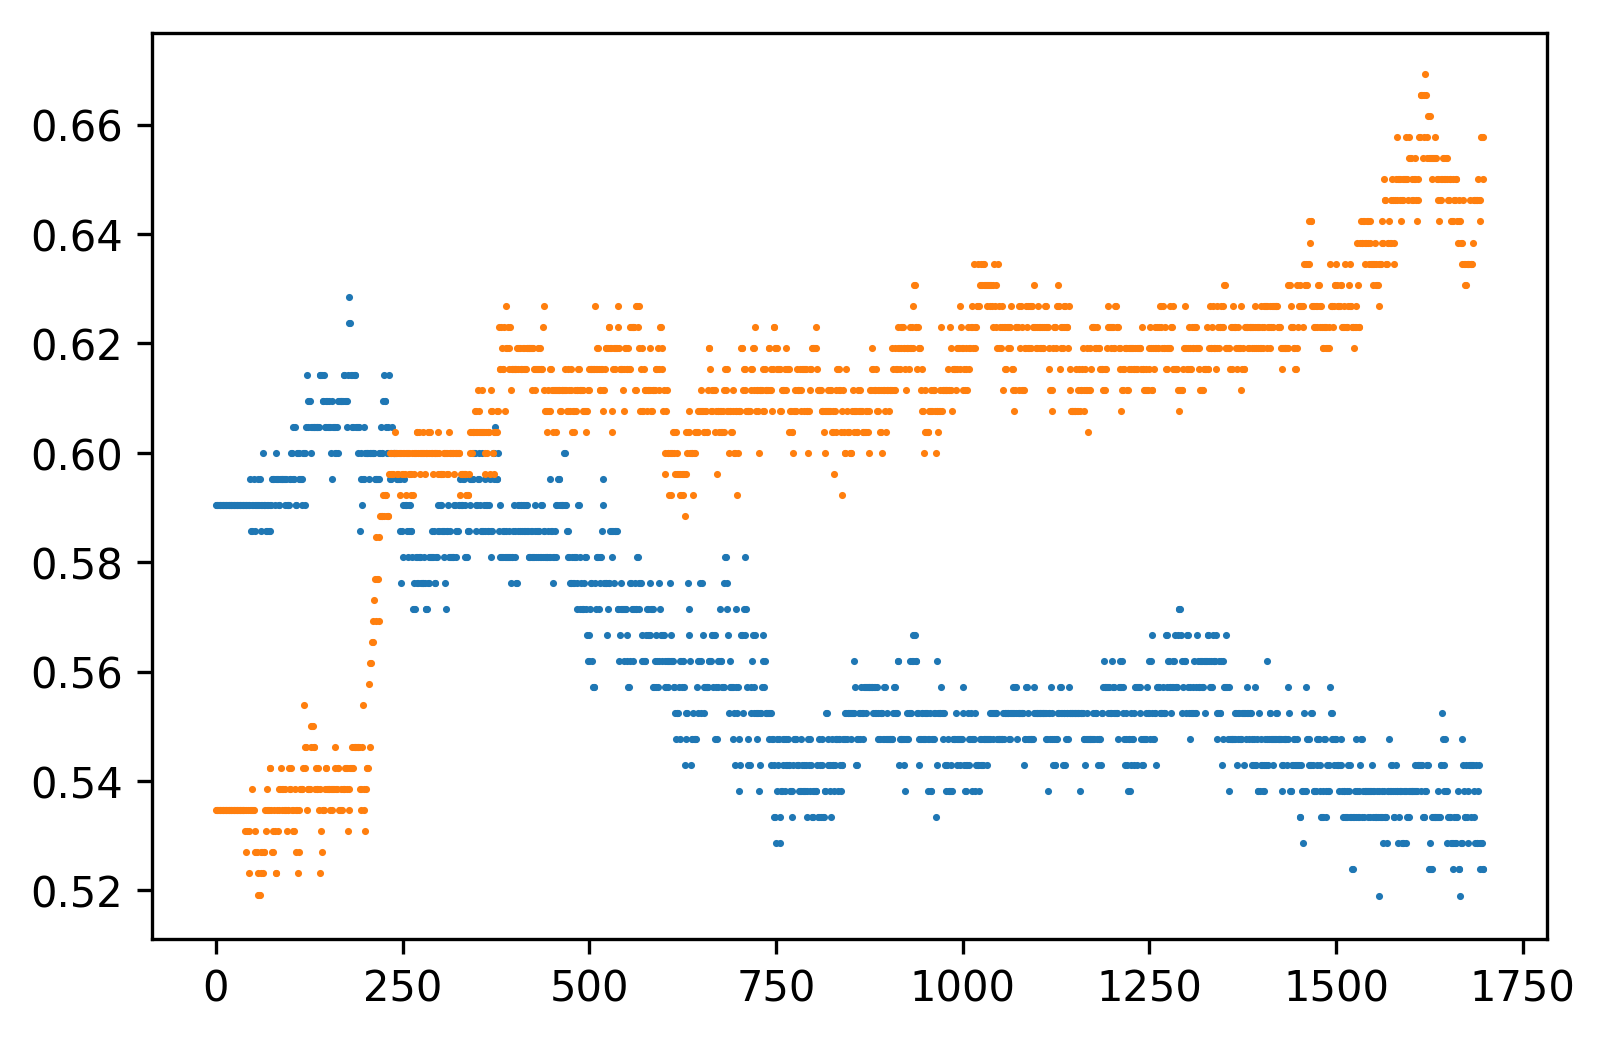

0.628571428571
178


In [4]:
# adagrad
results = numpy.array(results)
plt.figure(dpi=300)
plt.scatter(results[:,0], results[:,1], s=.5)
plt.scatter(results[:,0], results[:,3], s=.5)
plt.show()

print(max(results[:,1]))
print(results[:,1].tolist().index(max(results[:,1])))

In [ ]:
# rmsprop
results = numpy.array(results)
plt.figure(dpi=300)
plt.scatter(results[:,0], results[:,1], s=.5)
plt.scatter(results[:,0], results[:,2], s=.5)
plt.show()

print(max(results[:,1]))
print(results[:,1].tolist().index(max(results[:,1])))

In [ ]:
# adadelta
results = numpy.array(results)
plt.figure(dpi=300)
plt.scatter(results[:,0], results[:,1], s=.5)
plt.scatter(results[:,0], results[:,2], s=.5)
plt.show()

print(max(results[:,1]))
print(results[:,1].tolist().index(max(results[:,1])))

In [ ]:
# adam
results = numpy.array(results)
plt.figure(dpi=300)
plt.scatter(results[:,0], results[:,1], s=.5)
plt.scatter(results[:,0], results[:,3], s=.5)
plt.show()

print(max(results[:,1]))
print(results[:,1].tolist().index(max(results[:,1])))

In [ ]:
# sgd
results = numpy.array(results)
plt.figure(dpi=300)
plt.scatter(results[:,0], results[:,1], s=.5)
plt.scatter(results[:,0], results[:,2], s=.5)
plt.show()

print(max(results[:,1]))
print(results[:,1].tolist().index(max(results[:,1])))

In [ ]:
# results = results.tolist()
# for i in range(2000):
#     hist = model.fit(train_x, train_y, epochs=1, batch_size=200, verbose=0)
#     eva = _evaluate(test_x, test_y)
#     results.append([i, eva, hist.history['acc'][-1]])
#     print(i, hist.history, eva)
    
results.shape

In [ ]:
plt.figure(dpi=200)
plt.plot(dataset, linewidth=.5)
plt.show()

plt.figure(dpi=200)
plt.scatter(list(range(len(percent_inc))), percent_inc, s=.5)
plt.show()

In [ ]:
i = 2
test_x[i], test_y[i], model.predict(test_x[i:i+1])

In [ ]:
# results = results.tolist()
for i in range(2600, 4000):
    hist = model.fit(train_x, train_y, epochs=1, batch_size=200, verbose=0)
#     eva = _evaluate(test_x, test_y)
    eva = _evaluate_sigmoid(test_x, test_y)
    results.append([i, eva, hist.history['acc'][-1]])
    print(i, hist.history, eva)

In [ ]:
def _evaluate(x, y):
    predicts = [0,0,0,0,0,0,0,1]*test_x.shape[0]
    predicts= numpy.array(predicts).reshape(-1, 8).tolist()
    corrects = []
    for i in range(len(predicts)):
        index_max_predict = predicts[i].index(max(predicts[i]))
        index_max_reality = y[i].tolist().index(max(y[i]))
        if int(index_max_predict/4) == int(index_max_reality/4):
            corrects.append(1)
        else:
            corrects.append(0)
    return numpy.mean(corrects)
_evaluate(test_x, test_y)

In [ ]:
print(len(list(filter(lambda x: x < 0.0012 and x >= 0, percent_inc))))
print(len(list(filter(lambda x: x < 0.0025 and x >= 0.0012, percent_inc))))
print(len(list(filter(lambda x: x < 0.004 and x >= 0.0025, percent_inc))))
print(len(list(filter(lambda x: x > 0.004, percent_inc))))
print(len(list(filter(lambda x: x > -0.0012 and x <= 0, percent_inc))))
print(len(list(filter(lambda x: x > -0.0025 and x <= -0.0012, percent_inc))))
print(len(list(filter(lambda x: x > -0.004 and x <= -0.0025, percent_inc))))
print(len(list(filter(lambda x: x < -0.004, percent_inc))))

In [ ]:
dataset = pandas.read_csv('data_new/DowJones2.csv', skiprows=list(range(1, 2000)))['Close']
percent_inc = []
for i in range(1, len(dataset)):
    percent_inc.append((dataset[i]-dataset[i-1])/dataset[i])
percent_inc = numpy.array(percent_inc)

In [ ]:
_evaluate(test_x, test_y)

In [ ]:
corrects

In [ ]:
a = model.predict(test_x)[10]
print(sum(a[:4]))
print(sum(a[4:]))

In [ ]:
create_dataset(percent_inc, look_back=5, day_ahead=2, train_size=50)

In [ ]:
trend_inc[0:0+10:2]

In [ ]:
train_x.shape

In [ ]:
test_x.shape

In [ ]:
train_y[:80]

In [ ]:
print(len(list(filter(lambda x: x >= 0.005, percent_inc[:260]))))
print(len(list(filter(lambda x: x < 0.005 and x >= 0.002, percent_inc[:260]))))
print(len(list(filter(lambda x: x < 0.002 and x >= 0.0001, percent_inc[:260]))))
print(len(list(filter(lambda x: x < 0.001 and x >= 0, percent_inc[:260]))))

print(len(list(filter(lambda x: x >= -0.001 and x < 0, percent_inc[:260]))))
print(len(list(filter(lambda x: x >= -0.002 and x < -0.001, percent_inc[:260]))))
print(len(list(filter(lambda x: x >= -0.005 and x < -0.002, percent_inc[:260]))))
print(len(list(filter(lambda x: x < -0.005, percent_inc))))

In [ ]:
for i in range(0, 20, 2):
    print(train_x[i], train_y[i])

In [9]:
test_x.shape


(210, 5, 1)